## Differential Expression Analysis - RhithroLoxo

If you've already saved the workspace image from a previous session, jupyter should automatically reload it. You may need to reload the packages though. The .RData file is not on GitHub, so you will have to actually run it the first time through. 

First, make sure you're actually running this from a compute node, not the login. On Poseidon, logins are 'l1' and 'l2', whereas all other nodes start with 'pn'.

In [1]:
Sys.info()

sysname                               release 
                              "Linux"           "3.10.0-693.2.2.el7.x86_64" 
                              version                              nodename 
"#1 SMP Tue Sep 12 22:26:13 UTC 2017"                               "pn056" 
                              machine                                 login 
                             "x86_64"                             "unknown" 
                                 user                        effective_user 
                            "ztobias"                             "ztobias"

Now load in the packages.

In [2]:
require(DESeq2)
require(ggplot2)
require(apeglm)
require(ashr)
library("BiocParallel")
register(MulticoreParam(36))
require(VennDiagram)
require(RColorBrewer)
require(pheatmap)

Loading required package: DESeq2
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching p

Now import the count data, rounding decimals to integers.

In [3]:
path_to_main <- "/vortexfs1/scratch/ztobias/RhithroLoxo_DE/" #change accordingly based on parent file structure
path_to_counts <- "outputs/quant/salmon.isoform.counts.matrix"
path <- paste(path_to_main,path_to_counts,sep="")
all_counts <- read.table(path,header=TRUE)
all_counts <- round(all_counts)

Take a look.

In [4]:
head(all_counts)
dim(all_counts)

,AP_C_1,AP_C_2,AP_C_3,AP_C_4,AP_C_5,AP_C_6,AP_P_1,AP_P_2,AP_P_3,AP_P_6,...,NJ_P_7,SC_C_12,SC_C_14,SC_C_2,SC_C_6,SC_C_7,SC_C_9,SC_P_1,SC_P_2,SC_P_3
TRINITY_DN38930_c0_g1_i1,71,201,88,108,84,156,46,69,43,68,...,80,51,80,84,55,56,63,66,69,39
TRINITY_DN61353_c1_g1_i1,0,5,0,1,1,0,0,2,0,2,...,0,0,1,0,0,2,1,5,2,0
TRINITY_DN130836_c0_g1_i1,2,7,0,14,6,0,1,9,5,7,...,18,7,10,2,2,3,7,10,7,6
TRINITY_DN135735_c0_g1_i1,1,3,1,4,3,0,0,1,0,2,...,2,1,2,0,0,0,2,3,1,2
TRINITY_DN142305_c0_g1_i1,0,0,2,0,2,3,0,1,1,0,...,3,3,0,1,1,0,3,0,4,0
TRINITY_DN107975_c0_g1_i1,0,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 149511     83

Read in the sample metadata and have a look.

In [5]:
path_to_meta <- paste(path_to_main,"metadata/DESeq2_coldata.txt",sep="")
coldata <- read.table(path_to_meta,header=FALSE,row.names=1)
colnames(coldata) <- c("site","condition","range","sex")
head(coldata)
dim(coldata)

,site,condition,range,sex
AP_C_1,AP,C,Native,F
AP_C_2,AP,C,Native,F
AP_C_3,AP,C,Native,M
AP_C_4,AP,C,Native,M
AP_C_5,AP,C,Native,M
AP_C_6,AP,C,Native,M


[1] 83  4

Make sure the two matrices contain all of the same samples and are in order.

In [6]:
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

Okay here I am just going to calculate the normalized counts so I can try to identify transcripts whose highest representation occurs in the Loxo libraries. This is because there appears to be some latent contamination, either from index hopping or basal levels infection in otherwise "uninfected" crabs. This shows up downstream in some crazily overexpressed transcripts in the parasitized individuals, which appear not to be an actual response, but rather just contamination with parasite mRNA. This might not help completely because of tissue specific expression in the parasite (libraries made from externae, while contamination from internal, root-system tissues), but worth a shot. At least to strengthen the case for removal by thresholding later. 

The infected crabs will be excluded from this comparison. Because of tissue specific expression in the parasite, the highest expression of some contaminant transcripts may be expected in the infected crab libraries rather than those of the parasite itself. Thus, we are just looking for transcripts that are more highly represented in the parasite libraries than the control crab libraries.

Create a DESeq dataset for calculating normalized counts

In [7]:
contam <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ condition )

converting counts to integer mode


Estimate size factors and save normalized counts to object 'norm_mat'

In [8]:
contam <- estimateSizeFactors(contam)
norm_mat <- counts(contam, normalized=TRUE)

First let's remove the parasitized crabs. This includes all samples with the naming pattern `*_P_*`. The function `grepl()` returns a boolean vector that can be used to index. I will also remove sample MD_C_12, as this was identified to have a latent infection (unidentified infection detected in previous runs of this analysis).

In [9]:
norm_mat_sub <- norm_mat[,!grepl("*_P_*", colnames(norm_mat))]
norm_mat_sub <- subset(norm_mat_sub, select=-c(MD_C_12))

In [10]:
colnames(norm_mat_sub)

[1] "AP_C_1"  "AP_C_2"  "AP_C_3"  "AP_C_4"  "AP_C_5"  "AP_C_6"  "FP_C_10"
 [8] "FP_C_11" "FP_C_12" "FP_C_13" "FP_C_5"  "FP_C_9"  "LA_C_1"  "LA_C_2" 
[15] "LA_C_3"  "LA_C_4"  "LA_C_6"  "LA_C_8"  "LA_F_1"  "MA_C_1"  "MA_C_2" 
[22] "MA_C_4"  "MD_C_10" "MD_C_11" "MD_C_1"  "MD_C_4"  "MD_C_7"  "MD_F_4" 
[29] "ML_C_10" "ML_C_2"  "ML_C_3"  "ML_C_5"  "ML_C_7"  "ML_C_9"  "NH_C_11"
[36] "NH_C_12" "NH_C_13" "NH_C_5"  "NH_C_8"  "NH_C_9"  "NJ_C_10" "NJ_C_11"
[43] "NJ_C_12" "NJ_C_13" "NJ_C_14" "NJ_C_6"  "SC_C_12" "SC_C_14" "SC_C_2" 
[50] "SC_C_6"  "SC_C_7"  "SC_C_9"

Column numbers of the parasite samples in norm_mat_sub are 19 and 28. Command below finds the index of the maximum column for each row, checks if it matches 19 or 28 (the parasite samples), returns boolean which is used to subset the dataframe.  Let's take a look at a slice of the output to verify it's behavior. Parasite samples follow the naming pattern `*_F_*`.

In [11]:
contam_subset <- norm_mat_sub[max.col(norm_mat_sub) %in% c(19,28),]
contam_subset[1:20,18:29]

,LA_C_8,LA_F_1,MA_C_1,MA_C_2,MA_C_4,MD_C_10,MD_C_11,MD_C_1,MD_C_4,MD_C_7,MD_F_4,ML_C_10
TRINITY_DN130836_c0_g1_i1,8.342821,4515.9519,5.394225,1.521581,5.038778,5.136595,4.485368,4.048551,5.319531,4.6419802,729.6896,2.551833
TRINITY_DN6090_c0_g1_i1,114.018547,0.0000,149.959461,164.330783,157.461801,181.493023,146.522028,222.670320,189.729921,180.6152294,364.8448,146.305106
TRINITY_DN27882_c0_g1_i1,9.733291,694.7618,15.103831,10.651069,5.038778,14.553686,7.475614,14.169929,11.525649,9.2839604,0.0000,10.207333
TRINITY_DN33032_c0_g1_i1,8.342821,694.7618,6.473070,9.129488,10.077555,9.417091,5.232930,6.072827,5.319531,5.9079748,729.6896,18.713444
TRINITY_DN815_c0_g2_i2,241.246561,0.0000,189.876728,313.445753,311.144519,116.429487,217.540358,204.451839,134.761439,316.9206478,364.8448,281.552268
TRINITY_DN12072_c0_g1_i2,261.408377,694.7618,126.224870,176.503434,238.082243,173.788131,299.024547,118.757504,238.492284,166.2672906,1094.5344,249.229046
TRINITY_DN131921_c0_g1_i1,56.314039,347.3809,53.942252,53.255346,23.934194,84.753817,79.989066,103.238057,57.628247,80.1796579,0.0000,83.359886
TRINITY_DN29174_c0_g1_i1,72.999680,347.3809,93.859519,80.643810,119.670969,63.351338,78.493944,95.140955,58.514836,142.2133932,0.0000,85.061108
TRINITY_DN39441_c0_g1_i1,25.723697,0.0000,43.153802,34.996371,22.674499,35.956165,38.873191,22.267032,32.803771,13.0819442,729.6896,143.753273
TRINITY_DN26877_c0_g1_i1,26.418932,694.7618,7.551915,4.564744,11.337250,24.826876,32.892700,18.218481,25.711064,16.4579298,0.0000,15.310999


Scrolling through, it's clear that these transcripts have the highest expression in at least one of the parasite samples. This is indicative of Loxo contamination in the Rhithro assembly. Interestingly, oftentimes even when the highest value is in a parasite column, the other parasite column has a value of zero. I am not quite sure what this could mean. Different expression patterns between the two parasite externae, with both ending up in the Rhithro assembly? 

Okay now I'm going to save the rownames for use later:

In [12]:
contam_IDs <- rownames(contam_subset)
length(contam_IDs)

[1] 5797

There are 5797 transcripts that have higher expression in a parasite sample than any of the "clean" samples. It's a large number, but relative to the ~150K transcripts, not really.

Back to regularly scheduled programming. I am now going to remove the Loxo samples from the raw expression matrix and sample metadata, and make another DESeq dataset object. 

In [13]:
all_counts <- all_counts[,-c(29,41)]
coldata <- coldata[-c(29,41),]

Verify again that the counts and metadata match up:

In [14]:
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

Okay let's get started. This part of the analysis is just going to do a base comparison between uninfected and parasitized, controlling for population-specific effects. 

In [15]:
dds <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~site + condition)

converting counts to integer mode
factor levels were dropped which had no samples


In [ ]:
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing


Let's visualize the data using some PCAs. This will be helpful for identifying sample outliers.

First we'll apply a variance stabilizing transformation to our normalized counts. 

In [ ]:
vsd <- vst(dds, blind=FALSE)

In [ ]:
PCA <- plotPCA(vsd, intgroup="condition")
PCA + geom_label(aes(label = name))

You can see that PCA 1 clearly separates the sample according to infection status. Along the second PCA axis, you can see four extreme outlier at the upper left corner. Let's investigate this a little more closely by looking at the expression of particular high variance transcripts. 

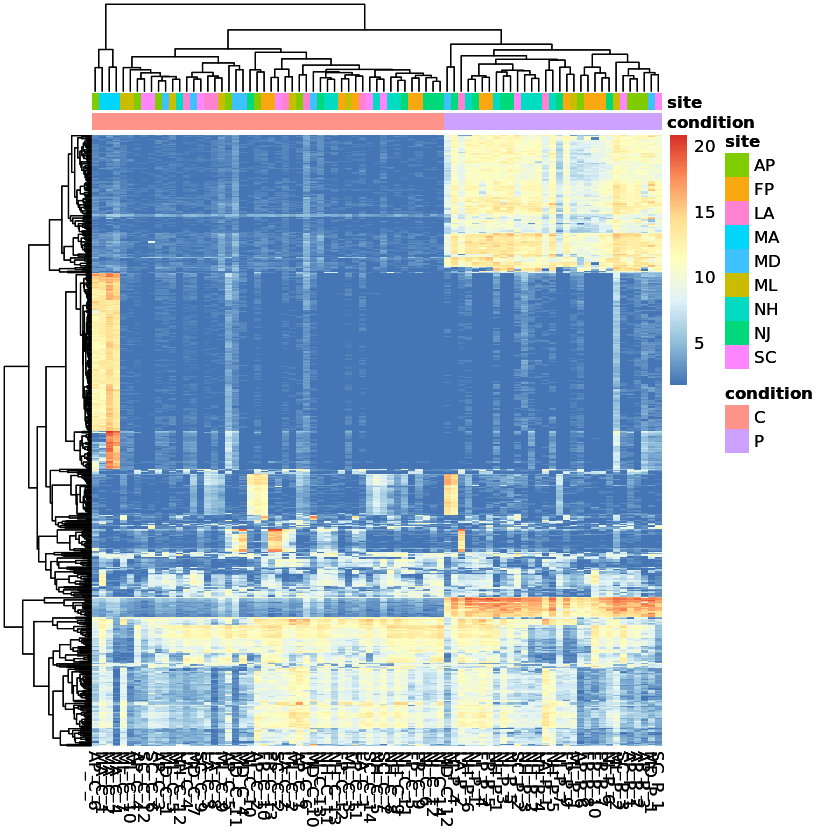

In [79]:
topVarGenes <- head(order(rowVars(assay(vsd)), decreasing = TRUE), 500)
df <- as.data.frame(colData(dds)[,c("condition","site")])
vsd_df <- assay(vsd)
heatmap <- pheatmap(vsd_df[topVarGenes,], cluster_rows=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)
heatmap

Looking at the top 500 highest variance transcripts, you can see that the transcript cluster second from the top separates samples in the same way as PCA axis 2 from above, with MA_C_1, MA_C_2, MA_C_4, and AP_C_6 having really high expression. Let's figure out what those are. 

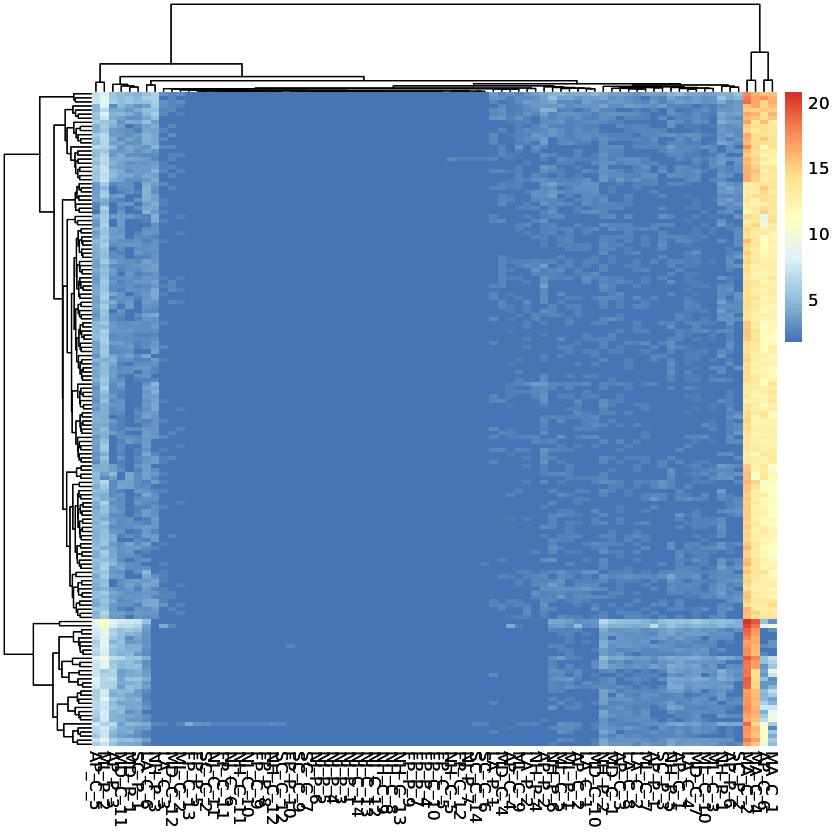

In [195]:
idx <- sort(cutree(heatmap$tree_row, k=10)) #separate transcripts by cluster assignment
idx <- names(which(idx==6)) #after searching, cluster 6 is the one with the transcripts we want
heatmap2 <- pheatmap(vsd_df[idx,], cluster_rows=TRUE, show_rownames=FALSE, #plot
         cluster_cols=TRUE)
heatmap2

Okay now we found the cluster that has all of these transcripts. Let's get the names and search annotations. Load in annotations.

In [193]:
annot <- read.table("../EnTAP/entap_outfiles/similarity_search/DIAMOND/overall_results/best_hits_lvl0.tsv", sep="\t", fill=TRUE, header=TRUE, quote="")

In [192]:
idx2 <- rownames(vsd[heatmap2$tree_row[["order"]],]) #get rownames of the transcripts in this cluster
outlier_annot <- annot[annot[,1] %in% rownames(vsd[idx2,]),] #get matching annotations
outlier_annot[order(outlier_annot[,11]),c(1,2,3,11,12,13,14)] #show results

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
14402,TRINITY_DN63617_c0_g1_i1,tr|A0A224Z7V0|A0A224Z7V0_9ACAR,51.6,1.6e-283,71.0,tr|A0A224Z7V0|A0A224Z7V0_9ACAR Tick transposon OS=Rhipicephalus zambeziensis OX=60191 PE=4 SV=1,rhipicephalus zambeziensis
17461,TRINITY_DN12072_c0_g1_i2,XP_027207344.1,52.7,2.4e-250,51.3,XP_027207344.1 uncharacterized protein LOC113800756 [Penaeus vannamei],penaeus vannamei
19483,TRINITY_DN144418_c0_g1_i1,XP_027212670.1,72.1,7.0e-221,93.6,XP_027212670.1 LOW QUALITY PROTEIN: chondroitin sulfate N-acetylgalactosaminyltransferase 1-like [Penaeus vannamei],penaeus vannamei
15644,TRINITY_DN53652_c0_g1_i1,XP_027228515.1,59.3,1.1e-167,86.9,XP_027228515.1 aladin-like [Penaeus vannamei],penaeus vannamei
8423,TRINITY_DN5678_c0_g1_i4,XP_027232370.1,63.5,1.9e-125,81.1,XP_027232370.1 leucine-rich repeat-containing protein 47-like [Penaeus vannamei],penaeus vannamei
18711,TRINITY_DN147159_c0_g1_i1,RXG54531.1,43.9,9.7e-109,96.3,RXG54531.1 FRAS1-related extracellular matrix protein 3 [Armadillidium vulgare],armadillidium vulgare
1790,TRINITY_DN29745_c1_g1_i1,XP_027236394.1,48.5,1.0e-92,53.0,XP_027236394.1 LOW QUALITY PROTEIN: BTB/POZ domain-containing protein 6-A-like [Penaeus vannamei],penaeus vannamei
2422,TRINITY_DN10013_c0_g1_i1,XP_027226048.1,55.8,3.6e-91,60.0,XP_027226048.1 failed axon connections homolog [Penaeus vannamei],penaeus vannamei
6794,TRINITY_DN801_c0_g1_i1,XP_027226631.1,62.8,1.1e-87,55.6,XP_027226631.1 poly(U)-specific endoribonuclease homolog [Penaeus vannamei],penaeus vannamei
4349,TRINITY_DN23772_c0_g1_i2,tr|A0A1B6LTA1|A0A1B6LTA1_9HEMI,44.1,7.6e-69,77.5,tr|A0A1B6LTA1|A0A1B6LTA1_9HEMI Uncharacterized protein OS=Graphocephala atropunctata OX=36148 GN=g.31387 PE=3 SV=1,graphocephala atropunctata


There doesn't seem to be anything special about these transcripts. I expected them to be contamination from some other parasite, but it seems that they actually represent crab genes (if we can trust the taxonomic assignmnet of what's in the reference databases). I will dig into this a bit more later. It is likely they reflect some other process in the crab, such as molting, both Carolyn and I previously observed in earlier rounds of this analysis...

Either way, I am going to remove these outlier samples. They are contributing too much variation and will present issues when trying to fit the DESeq2 models and cause issues with count normalization. 

In [199]:
all_counts <- all_counts[,!(colnames(all_counts) %in% c("MA_C_1","MA_C_2","MA_C_4","AP_C_6"))]
all_counts[1:6,1:6]
dim(all_counts)

,AP_C_1,AP_C_2,AP_C_3,AP_C_4,AP_C_5,AP_P_1
TRINITY_DN38930_c0_g1_i1,71,201,88,108,84,46
TRINITY_DN61353_c1_g1_i1,0,5,0,1,1,0
TRINITY_DN130836_c0_g1_i1,2,7,0,14,6,1
TRINITY_DN135735_c0_g1_i1,1,3,1,4,3,0
TRINITY_DN142305_c0_g1_i1,0,0,2,0,2,0
TRINITY_DN107975_c0_g1_i1,0,0,0,0,0,0


[1] 149511     77

Okay now you can see the four of them were removed. Now make sure the coldata matches.

In [200]:
coldata <- coldata[colnames(all_counts),]
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

Okay good let's make another dds object.

In [201]:
dds <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ condition)

converting counts to integer mode
factor levels were dropped which had no samples


In [202]:
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 11126 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [204]:
res <- results(dds, alpha=0.05)
summary(res)


out of 146149 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1328, 0.91%
LFC < 0 (down)     : 1132, 0.77%
outliers [1]       : 0, 0%
low counts [2]     : 43058, 29%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Here we see that there are 1328 transcripts deemed significantly upregulated in parasitized crabs, and 1132 significantly downregulated. 

As mentioned earlier, it is my suspicion that some of these upregulated transcripts are contamination from Loxo. Let's have a look.

In [205]:
resLFC <- lfcShrink(dds, coef="condition_P_vs_C", type="apeglm")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895


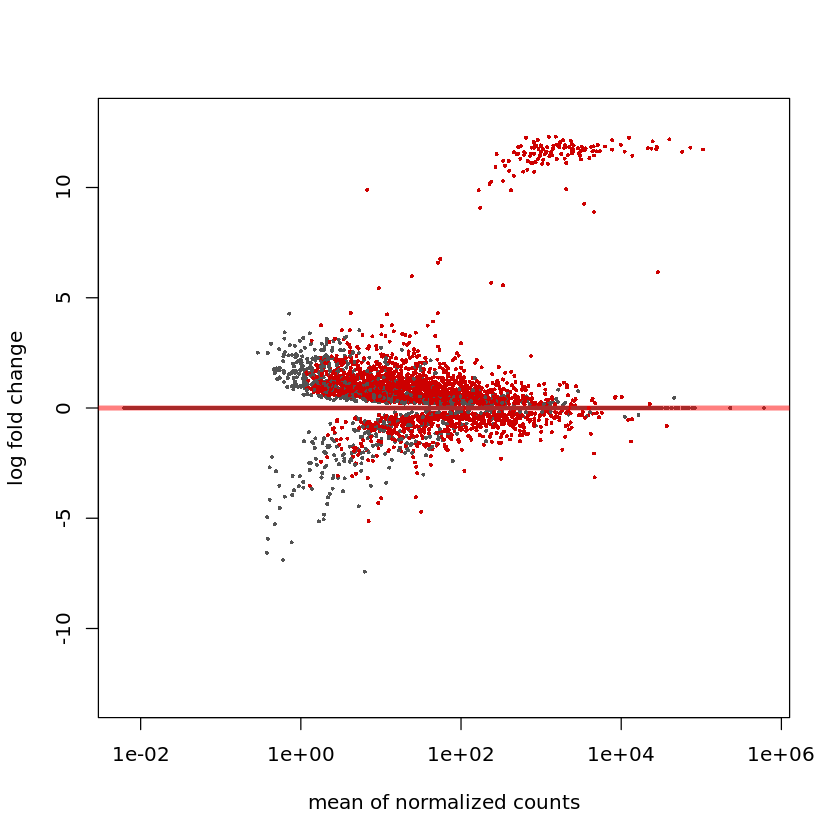

In [206]:
plotMA(resLFC, ylim=c(-13,13))

Here we see the pattern I have alluded to, where there is a cloud of extremely overexpressed (>10 LFC) in the infected relative to the control. It is my suspicion that these represent contamination from Loxo rather than an actually response by the crabs. 

Let's see if these match the transcript IDs we pulled out earlier as possible Loxo contaminant transcripts. 

First let's make an ordered data.frame of the significant transcripts.

In [214]:
res_sig <- data.frame(subset(res, padj < 0.05))
res_sig <- res_sig[order(-res_sig$log2FoldChange),]
head(res_sig, 30)
tail(res_sig)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN85899_c0_g1_i1,1520.9840,12.34382,0.4676799,26.39374,1.616898e-153,2.395272e-150
TRINITY_DN98899_c0_g1_i1,1240.7721,12.32642,0.4018960,30.67066,1.401515e-206,8.074131e-203
TRINITY_DN80409_c0_g1_i1,12481.4717,12.28205,0.3924896,31.29268,5.869259e-215,4.681773e-211
TRINITY_DN74741_c0_g1_i1,648.6235,12.22559,0.5088851,24.02426,1.551367e-127,1.489571e-124
TRINITY_DN19987_c0_g1_i1,39911.4587,12.19625,0.3401189,35.85879,1.341673e-281,6.956440e-277
TRINITY_DN135642_c0_g1_i1,1873.8899,12.19093,0.5637127,21.62613,1.019819e-103,9.038731e-101
TRINITY_DN134734_c0_g1_i1,909.5380,12.18094,0.4792203,25.41824,1.585434e-142,1.868253e-139
TRINITY_DN50085_c0_g1_i1,7704.0330,12.15918,0.4173643,29.13325,1.361819e-186,3.922720e-183
TRINITY_DN60860_c0_g1_i1,2336.7614,12.14937,0.4411119,27.54260,5.427078e-167,1.042180e-163
TRINITY_DN50011_c0_g1_i1,24641.8060,12.11206,0.4066842,29.78246,6.591459e-195,2.531560e-191


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN35786_c0_g1_i1,7.853278,-6.528988,1.5674723,-4.165297,3.109470e-05,3.362313e-03
TRINITY_DN16990_c0_g1_i1,23.339755,-6.857153,1.1158458,-6.145252,7.983686e-10,3.077666e-07
TRINITY_DN1835_c0_g1_i2,63.702057,-6.907201,1.3030163,-5.300932,1.152127e-07,2.865067e-05
TRINITY_DN146456_c0_g1_i1,13.241038,-6.988593,1.4950995,-4.674333,2.949108e-06,4.900907e-04
TRINITY_DN4309_c0_g1_i2,227.364696,-7.237664,0.9907596,-7.305166,2.769237e-13,1.457687e-10
TRINITY_DN7953_c0_g1_i1,25.403098,-7.256725,1.3776410,-5.267501,1.382936e-07,3.358494e-05


You can see that there are some extremely significant, extremely overexpressed transcripts at the top, many of which have high rates of expression overall. These are likely contamination from Loxo. I am going to compare the list of transcripts I made earlier to these to see how much of an overlap there is. 

There are 2377 significant transcripts, 1250 up and 1127 down. There were 5797 transcripts that had higher expression in one of the two parasite samples than any of the clean samples. Let's look at the intersect. 

In [215]:
contam_intersect <- intersect(contam_IDs, rownames(res_sig))
length(contam_intersect)

[1] 459

Okay so there are 452 transcripts that came up as significant that were also identified as potential contamination. Let's take a look at the significant results table with those removed:

In [216]:
head(res_sig[!(rownames(res_sig) %in% contam_intersect),],n=10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN22600_c0_g1_i1,4.362677,5.519511,0.8159560,6.764472,1.337962e-11,6.249730e-09
TRINITY_DN27254_c0_g1_i1,20.741130,4.181607,0.8183592,5.109746,3.225930e-07,7.099971e-05
TRINITY_DN706_c3_g1_i1,2.231154,4.151526,1.1981173,3.465041,5.301504e-04,2.839646e-02
TRINITY_DN109614_c0_g1_i1,36.134287,3.874090,0.9091310,4.261311,2.032315e-05,2.381322e-03
TRINITY_DN146992_c0_g1_i1,5.882913,3.742718,0.8447508,4.430558,9.398951e-06,1.290930e-03
TRINITY_DN56560_c0_g1_i1,14.465774,3.610151,0.4896321,7.373192,1.665902e-13,8.950812e-11
TRINITY_DN82187_c0_g1_i1,10.137182,3.598683,0.6660874,5.402718,6.563858e-08,1.758809e-05
TRINITY_DN51295_c0_g1_i1,18.506585,3.596144,0.6445518,5.579293,2.414978e-08,7.133634e-06
TRINITY_DN84163_c0_g1_i1,27.165378,3.564960,0.5013343,7.110944,1.152521e-12,5.801655e-10
TRINITY_DN76798_c0_g1_i1,1.781217,3.525780,1.0149129,3.473973,5.128136e-04,2.781113e-02


A lot of those transcripts are now removed. There are just around 7 of them left, depending on where you draw the line.

I am going to repeat the lfc shrinking and visualization with the contam transcrips removed. I am subsetting the dds object within the `lfcShrink()` function, using `subset()` to keep only transcripts that do not appear in the contam_IDs list. 

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895


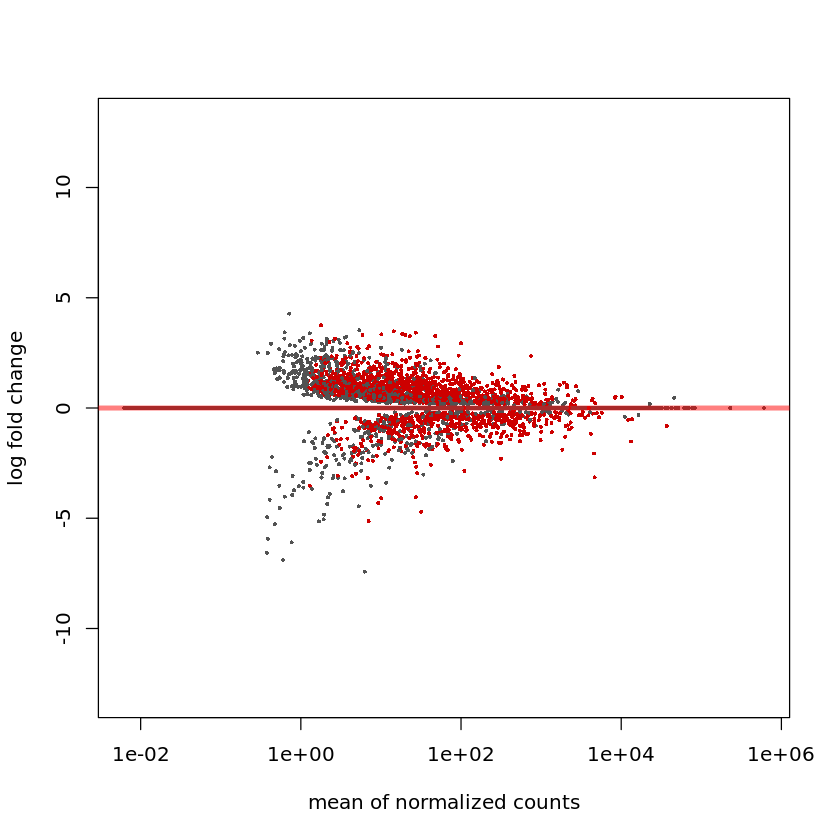

In [217]:
resLFC_nocontam <- lfcShrink(subset(dds, !rownames(dds) %in% contam_IDs), coef="condition_P_vs_C", type="apeglm")
plotMA(resLFC_nocontam, ylim=c(-13,13))

You can see now that the big cloud of points at the top right has mostly disappeared. A few points remain. I am still going to consider these as contamination and remove them. I am going to do this by considering transcripts that are overexpressed above the absolute value of the LFC of the most underexpressed significant transcript. This is done using the shrunk LFCs for ranking purposes.

In [218]:
resLFC_nocontam_sig <- data.frame(subset(resLFC_nocontam, padj < 0.05))
resLFC_nocontam_sig <- resLFC_nocontam_sig[order(-resLFC_nocontam_sig$log2FoldChange),]
head(resLFC_nocontam_sig,n=20)

,baseMean,log2FoldChange,lfcSE,pvalue,padj
TRINITY_DN76798_c0_g1_i1,1.781217,3.746941,1.0888893,5.128136e-04,3.405745e-02
TRINITY_DN56560_c0_g1_i1,14.465774,3.473322,0.4961500,1.665902e-13,1.382518e-09
TRINITY_DN84163_c0_g1_i1,27.165378,3.419379,0.5087831,1.152521e-12,5.738804e-09
TRINITY_DN51295_c0_g1_i1,18.506585,3.351588,0.6617950,2.414978e-08,2.096949e-05
TRINITY_DN82187_c0_g1_i1,10.137182,3.335844,0.6860929,6.563858e-08,4.539410e-05
TRINITY_DN146992_c0_g1_i1,5.882913,3.320420,0.8891357,9.398951e-06,2.039245e-03
TRINITY_DN61940_c0_g1_i1,20.182625,3.310412,0.4699711,1.196326e-13,1.191385e-09
TRINITY_DN35566_c0_g1_i1,47.657603,3.267471,0.4609772,9.151476e-14,1.012631e-09
TRINITY_DN79806_c0_g1_i1,22.932887,3.259098,0.4545289,7.999825e-09,9.598537e-06
TRINITY_DN89969_c0_g1_i1,2.668127,3.147877,0.9426323,3.340633e-04,2.543453e-02


Okay there's the table. Now find rownames of rows with higher LFC values than absolute value of lowest LFC value. 

In [219]:
contam_add <- rownames(resLFC_nocontam_sig[resLFC_nocontam_sig$log2FoldChange > abs(min(resLFC_nocontam_sig$log2FoldChange)),])
contam_add

character(0)

Okay here the seven remaining contigs that we will consider contamination. I am going to add them to the list of contam_IDs, which will be used for removal from the intial counts object. Then the analysis will be re-run. This is to account for renormalization after removal, since many of these contigs had high mean expression across samples. I also want to have all of the putative contaminant transcripts removed before I do the WGCNA analysis. Because it looks for co-expression patterns among transcripts, if I leave in transcripts that are actually just contaminants, it will likely assign transcripts to modules not based on any functional relevance to particular pathways, but rather just to infection status. 

In [220]:
contam_IDs <- c(contam_IDs, contam_add)
length(contam_IDs)

[1] 5804

Okay successfully added. Now to reperform the anaysis.

In [221]:
dim(all_counts)
counts_clean <- all_counts[!rownames(all_counts) %in% contam_IDs,]
dim(counts_clean)

[1] 149511     77

[1] 143707     77

You can see that the 5804 putative contaminant transcripts have been removed.

Check that the sample names match between metadata and counts matrices.

In [222]:
all(rownames(coldata) == colnames(counts_clean))

[1] TRUE

Good. Create new dds object without the contaminant transcripts.

In [223]:
dds_clean <- DESeqDataSetFromMatrix(countData = counts_clean, colData = coldata, design = ~ condition)

converting counts to integer mode
factor levels were dropped which had no samples


Fit the model.

In [224]:
dds_clean <- DESeq(dds_clean)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 11029 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [225]:
res_clean <- results(dds_clean, alpha=0.05)
summary(res_clean)


out of 140353 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 883, 0.63%
LFC < 0 (down)     : 935, 0.67%
outliers [1]       : 0, 0%
low counts [2]     : 41373, 29%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Now you can see that we have 883 significantly upregulated transcripts and 935 significantly downregulated transcripts. There were a lot of transcripts that had too low of counts to be included (41373), though the creators of DESeq2 recommend not removing these before-hand because have all of the transcripts helps with the dispersion estimates. So, even though a lot got "thrown out", they are still helpful behind the scenes. 

Now I'll just save all of the significant results into a table.

In [226]:
res_clean_sig <- data.frame(subset(res_clean, padj < 0.05))
res_clean_sig <- res_clean_sig[order(res_clean_sig$padj),]
head(res_clean_sig, 20)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN2290_c0_g1_i1,129.67184,-4.586661,0.5558085,-8.252233,1.554621e-16,1.548201e-11
TRINITY_DN21375_c0_g1_i1,750.13158,2.437766,0.2991848,8.148026,3.699137e-16,1.841930e-11
TRINITY_DN129162_c0_g1_i1,99.79871,3.035223,0.3791467,8.005406,1.190732e-15,3.952713e-11
TRINITY_DN28_c10_g1_i1,1132.20916,-5.177285,0.6551594,-7.902329,2.737405e-15,6.815248e-11
TRINITY_DN112882_c0_g1_i1,13.39989,1.681456,0.2146399,7.833844,4.731755e-15,9.424426e-11
TRINITY_DN9438_c0_g1_i1,142.56839,-5.880431,0.7650680,-7.686156,1.516222e-14,2.516599e-10
TRINITY_DN58794_c0_g1_i1,61.21282,1.687940,0.2244388,7.520716,5.447710e-14,7.750301e-10
TRINITY_DN35566_c0_g1_i1,47.75232,3.399020,0.4554925,7.462298,8.502662e-14,1.049912e-09
TRINITY_DN29984_c0_g1_i1,44.80880,-4.244960,0.5699589,-7.447836,9.488399e-14,1.049912e-09
TRINITY_DN61940_c0_g1_i1,20.21961,3.445981,0.4637618,7.430498,1.081898e-13,1.077430e-09


Just out of curiosity, I'd like to plot the counts for a few top transcripts. 

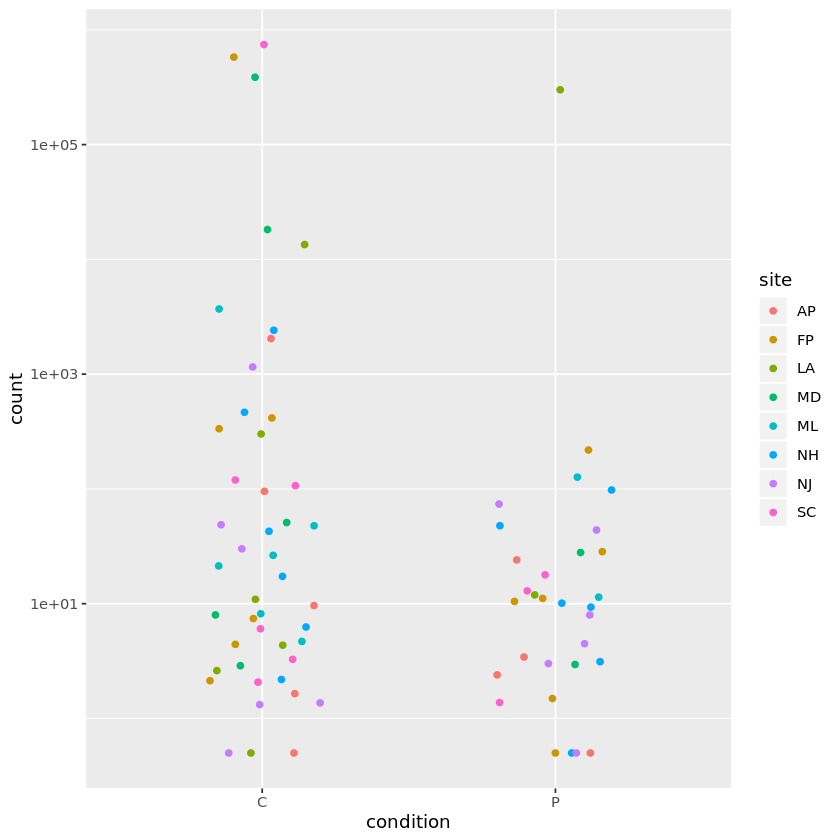

In [237]:
count_plot <- plotCounts(dds_clean, gene="TRINITY_DN4558_c1_g1_i1", intgroup=c("condition","site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, color=site)) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    scale_y_log10()


We'll do a variance stabilizing transformation, which is fast and useful for visualization of results.

*BLIND OR NOT?*

In [35]:

#vsd <- vst(dds_clean) #blind = TRUE or FALSE?

Now that we have looked for bulk differences as a result of infection status, we can move on to look at differences among populations with different levels of historical exposure to the parasite. We included the FP samples in our first comparison because it was agnostic to range. However, because it is unresolved whether Loxo is native, invasive, or absent from FP, we are going to remove it from subsequent analyses.

We have to make another dds object. I am going to make it from scratch by removing all FP samples from the coldata and counts_clean.

*WE PROBABLY WANT TO CHANGE THE MODEL FORMULA SO IT ACCOUNTS FOR POPULATION AS BATCH EFFECTS!*

<http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#group-specific-condition-effects-individuals-nested-within-groups>

In [36]:
counts_clean_noFP <- counts_clean[,!grepl("FP_*_*",colnames(counts_clean))]
coldata_noFP <- coldata[colnames(counts_clean_noFP),]

Just a quick sanity check to make sure the samples are in the same order in the counts and metadata matrices.

In [37]:
all(rownames(coldata_noFP) == colnames(counts_clean_noFP))

[1] TRUE

Good. Now we can specify the model design and the reference levels.

In [38]:
dds_interaction <- DESeqDataSetFromMatrix(countData = counts_clean_noFP, colData = coldata_noFP, design = ~ range + condition + range:condition)
dds_interaction$condition <- relevel(dds_interaction$condition, ref = "C")
dds_interaction$range <- relevel(dds_interaction$range, ref = "Native")

converting counts to integer mode
factor levels were dropped which had no samples


Let's make sure we have the design and levels we want. 

In [39]:
design(dds_interaction)
dds_interaction$condition
dds_interaction$range

~range + condition + range:condition

[1] C C C C C C P P P P C C C C C C P P C C C C C P C C C P C C C C C C P P C C
[39] C C C C P P P P P P C C C C C C P P P P P P C C C C C C P P P
Levels: C P

[1] Native   Native   Native   Native   Native   Native   Native   Native  
 [9] Native   Native   Native   Native   Native   Native   Native   Native  
[17] Native   Native   Absent   Absent   Absent   Invasive Invasive Invasive
[25] Invasive Invasive Invasive Invasive Invasive Invasive Invasive Invasive
[33] Invasive Invasive Invasive Invasive Absent   Absent   Absent   Absent  
[41] Absent   Absent   Absent   Absent   Absent   Absent   Absent   Absent  
[49] Absent   Absent   Absent   Absent   Absent   Absent   Absent   Absent  
[57] Absent   Absent   Absent   Absent   Invasive Invasive Invasive Invasive
[65] Invasive Invasive Invasive Invasive Invasive
Levels: Native Absent Invasive

We have our correct model formula. Clicking on the "Levels" arrow, we can see that "C" appears first for condition and "Native" appears first for range, indicating they are the reference level for their respective factors.

Now we can move on to running the analysis.

In [40]:
dds_interaction <- DESeq(dds_interaction)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 12206 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [41]:
resultsNames(dds_interaction)

[1] "Intercept"                "range_Absent_vs_Native"  
[3] "range_Invasive_vs_Native" "condition_P_vs_C"        
[5] "rangeAbsent.conditionP"   "rangeInvasive.conditionP"

Model fitting is now complete. Looking at `resultsNames()` tells us that we have all of the expected coefficients in our model. 

We are interested in a number of comparisons. First, we are simply interested in understanding which transcripts are differentially expressed between infected and uninfected crabs *within* each range. Let's save these results to their own data.frames.

In [42]:
native.PvC <- results(dds_interaction, alpha=0.05, contrast=c("condition","P","C"))
invasive.PvC <- results(dds_interaction, alpha=0.05, contrast=list( c("condition_P_vs_C","rangeInvasive.conditionP")))
absent.PvC <- results(dds_interaction, alpha=0.05, contrast=list( c("condition_P_vs_C","rangeAbsent.conditionP")))
summary(native.PvC)
summary(invasive.PvC)
summary(absent.PvC)


out of 143194 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 757, 0.53%
LFC < 0 (down)     : 478, 0.33%
outliers [1]       : 285, 0.2%
low counts [2]     : 75288, 53%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 143194 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3195, 2.2%
LFC < 0 (down)     : 1630, 1.1%
outliers [1]       : 285, 0.2%
low counts [2]     : 66975, 47%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 143194 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3889, 2.7%
LFC < 0 (down)     : 3350, 2.3%
outliers [1]       : 285, 0.2%
low counts [2]     : 44826, 31%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



*THIS WILL HAVE TO BE REDONE!*

Just a brief description of the results.

For the native range populations (AP & LA), there are 757 significantly upregulated transcripts and 478 significantly downregulated transcripts. In contrast, for the invasive range there are a lot more, with 3195 significantly upregulated and 1630 significantly downregulated transcripts. There are even more for the absent range, with a large boost in the number of downregulated over the invasive range. For the absent range, there are 3889 significantly upregulated and 3350 significantly downregulated transcripts. 

But is this all due to difference in historical exposure to the parasite? Or could it be an effect of differing numbers of samples between ranges? When you exclude FP (range unresolved) and MA_C_3 (bad seq data), there are a total of 18 native samples, 24 invasive samples, and 26 absent samples. So the elevated recovery of DE transcripts could  be due in part to deeper sampling/sequencing. I think the best normalization in this case would be library size, i.e. total bp in filtered reads from each of the three ranges as denominator, to see if this is an effect of sampling/sequencing effort. I am not sure if this is accounted for under the hood of DESeq2.

There is almost certainly another effect of which samples were used for the assembly. It was just the uninfected samples, although there are certainly disparaties among ranges as well as far as to what proportion of the assembly is derived from reads from that range. 

Now I'll save the significant results to data.frames:

In [43]:
native.PvC.df <- data.frame(subset(native.PvC, padj < 0.05))
invasive.PvC.df <- data.frame(subset(invasive.PvC, padj < 0.05))
absent.PvC.df <- data.frame(subset(absent.PvC, padj < 0.05))
native.PvC.df <- native.PvC.df[order(native.PvC.df$padj),]
invasive.PvC.df <- invasive.PvC.df[order(invasive.PvC.df$padj),]
absent.PvC.df <- absent.PvC.df[order(absent.PvC.df$padj),]

I am going to save the names of the up and downregulated transcripts in each range to objects for making Venn diagrams.

In [44]:
native_DE_up <- rownames(native.PvC.df[native.PvC.df$log2FoldChange > 0,])
invasive_DE_up <- rownames(invasive.PvC.df[invasive.PvC.df$log2FoldChange > 0,])
absent_DE_up <- rownames(absent.PvC.df[absent.PvC.df$log2FoldChange > 0,])
native_DE_down <- rownames(native.PvC.df[native.PvC.df$log2FoldChange < 0,])
invasive_DE_down <- rownames(invasive.PvC.df[invasive.PvC.df$log2FoldChange < 0,])
absent_DE_down <- rownames(absent.PvC.df[absent.PvC.df$log2FoldChange < 0,])

Now I'll make the Venn diagrams.

In [45]:
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")
myCol <- brewer.pal(3, "Set1")
venn.diagram(
        x = list(native_DE_up, invasive_DE_up, absent_DE_up),
        category.names = c("Native" , "Invasive" , "Absent"),
        filename = '../vis/venn_range_up.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)
venn.diagram(
        x = list(native_DE_down, invasive_DE_down, absent_DE_down),
        category.names = c("Native" , "Invasive" , "Absent"),
        filename = '../vis/venn_range_down.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)
venn.diagram(
        x = list(c(native_DE_down,native_DE_up), c(invasive_DE_down,invasive_DE_up), c(absent_DE_down,absent_DE_up)),
        category.names = c("Native" , "Invasive" , "Absent"),
        filename = '../vis/venn_range_both.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)

NULL

[1] 1

[1] 1

[1] 1

Now I am going to apply the LFC shrinkage for optimal ranking and visualization later on. We are using the `ashr` method. It tends to not overshrink the LFCs and is also compatible with contrasts. See the [DESeq2 vignette](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) for more details.

For determining significant transcripts above (in the summary and in making the Venn diagrams), the unshrunk LFC p-values were used, as recommended by the DESeq2 creator [here](https://support.bioconductor.org/p/98833/).

In [46]:
native.PvC.LFCshrink <- lfcShrink(dds_interaction, contrast=c("condition","P","C"), type="ashr")
invasive.PvC.LFCshrink <- lfcShrink(dds_interaction, contrast=list( c("condition_P_vs_C","rangeInvasive.conditionP")), type="ashr")
absent.PvC.LFCshrink <- lfcShrink(dds_interaction, contrast=list( c("condition_P_vs_C","rangeAbsent.conditionP")), type="ashr")

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041
using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041


*IN HERE WE'LL MAKE SOME PLOTS FOR WITHIN/AMONG GROUP STUFF*

Now on to looking into interactions between the infection status and range.

In [47]:
IvN <- results(dds_interaction, alpha=0.05, name="rangeInvasive.conditionP")
AvN <- results(dds_interaction, alpha=0.05, name="rangeAbsent.conditionP")
AvI <- results(dds_interaction, alpha=0.05, contrast=list("rangeAbsent.conditionP", "rangeInvasive.conditionP"))
summary(IvN)
summary(AvN)
summary(AvI)


out of 143194 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1813, 1.3%
LFC < 0 (down)     : 1953, 1.4%
outliers [1]       : 285, 0.2%
low counts [2]     : 58673, 41%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 143194 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 180, 0.13%
LFC < 0 (down)     : 545, 0.38%
outliers [1]       : 285, 0.2%
low counts [2]     : 72518, 51%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 143194 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4078, 2.8%
LFC < 0 (down)     : 3598, 2.5%
outliers [1]       : 285, 0.2%
low counts [2]     : 53140, 37%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



*WRITE SOME SHIT HERE TO SUMMARIZE ABOVE, BUT FIRST EXPLORE THE DATA*

In [48]:
IvN.df <- data.frame(subset(IvN, padj < 0.05))
AvN.df <- data.frame(subset(AvN, padj < 0.05))
AvI.df <- data.frame(subset(AvI, padj < 0.05))
IvN.df <- IvN.df[order(IvN.df$padj),]
AvN.df <- AvN.df[order(AvN.df$padj),]
AvI.df <- AvI.df[order(AvI.df$padj),]

In [118]:
head(IvN.df,60)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN38142_c0_g1_i2,9.556046,-22.383506,2.2609119,-9.900212,4.153945e-23,3.518267e-18
TRINITY_DN136252_c0_g1_i1,4.239486,24.865795,2.7128334,9.165987,4.909567e-20,2.079128e-15
TRINITY_DN142173_c0_g1_i1,2.695124,22.033548,2.8736031,7.667568,1.752877e-14,4.948780e-10
TRINITY_DN21593_c0_g1_i1,66.034963,10.335512,1.4021410,7.371236,1.690532e-13,3.579576e-09
TRINITY_DN32458_c0_g1_i1,34.384656,-4.624553,0.6803355,-6.797460,1.064797e-11,1.803702e-07
TRINITY_DN21043_c0_g1_i1,85.939387,10.304219,1.5481503,6.655826,2.817138e-11,3.976719e-07
TRINITY_DN7282_c0_g1_i1,247.147743,5.412608,0.8308829,6.514285,7.303682e-11,8.837142e-07
TRINITY_DN37436_c0_g1_i1,10.707536,-5.620953,0.8769969,-6.409320,1.461705e-10,1.238020e-06
TRINITY_DN69624_c0_g1_i1,4.280610,25.238317,3.9358178,6.412471,1.431798e-10,1.238020e-06
TRINITY_DN60996_c0_g1_i1,11.605630,-4.856085,0.7560883,-6.422642,1.339290e-10,1.238020e-06


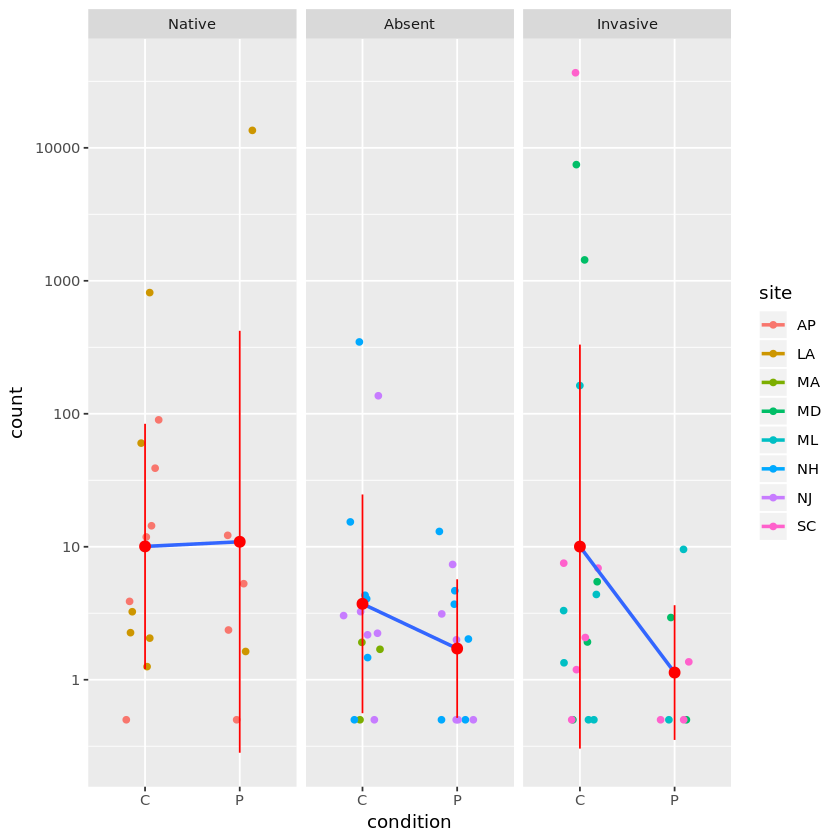

In [125]:
count_plot <- plotCounts(dds_interaction, gene="TRINITY_DN9438_c0_g1_i1", intgroup=c("condition","range", "site"), returnData=TRUE)
#count_plot
ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
    facet_grid(.~range) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
    #geom_line()+
    geom_smooth(method = "lm", se=F, aes(group=1)) +
    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
    scale_y_log10()#limits = c(1,1e6)) 

In [ ]:
#res_int_abs.P = results(dds_interaction, name="rangeAbsent.conditionP")
#res_int_inv.P = results(dds_interaction, name="rangeInvasive.conditionP")

In [ ]:
#summary(res_int_abs.P)
#summary(res_int_inv.P)

In [ ]:
#res_int_abs.P_sig <- data.frame(subset(res_int_abs.P, padj < 0.05))
#res_int_abs.P_sig <- res_int_abs.P_sig[order(res_int_abs.P_sig$padj),]
#res_int_inv.P_sig <- data.frame(subset(res_int_inv.P, padj < 0.05))
#res_int_inv.P_sig <- res_int_inv.P_sig[order(res_int_inv.P_sig$padj),]
#head(res_int_inv.P_sig,20)

In [ ]:
#count_plot <- plotCounts(dds_interaction, gene="TRINITY_DN7282_c0_g1_i1", intgroup=c("condition","range"), returnData=TRUE)
#ggplot(count_plot, aes(x=condition, y=count, color=range)) +
#    geom_point(position=position_jitter(w=0.2,h=0)) + 
#    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
#    scale_y_log10() 

In [ ]:
#count_plot <- plotCounts(dds_interaction, gene="TRINITY_DN7282_c0_g1_i1", intgroup=c("condition","range", "site"), returnData=TRUE)
##count_plot
#ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
#    facet_grid(.~range) +
#    geom_point(position=position_jitter(w=0.2,h=0)) + 
#    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
#    #geom_line()+
#    geom_smooth(method = "lm", se=F, aes(group=1)) +
#    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
#    scale_y_log10()#limits = c(1,1e6)) 

In [ ]:
#dim(assays(ddsMF_noFP)[[1]])
#print(data.frame(colData(dds_interaction)))

In [ ]:
#save.image()

In [62]:
?hist()

Before we finish, I need to export a matrix of counts to use downstream in WGCNA. The creators [suggest](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/faq.html) removing transcripts with consistently low counts to avoid spurious correlations, and the also recommend performing a variance stabilizing transformation. I will do both below and then export as an R data object.

I am removing all transcripts that have normalized counts of less than 10 in over 90% of the samples (72/81).

In [116]:
filterGenes <- rowSums(counts(dds_clean, normalized=TRUE) < 10 ) > 72
for_export <- dds_clean[!filterGenes,]
vsd <- vst(for_export, blind=TRUE)
write.table(assays(vsd)[[1]], file = "../outputs/WGCNA_in.tsv", sep="\t")

In [ ]:
annot <- read.table("../EnTAP/entap_outfiles/similarity_search/DIAMOND/overall_results/best_hits_lvl0.tsv", sep="\t", fill=TRUE, header=TRUE, quote="")